In [ ]:
import pandas as pd

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.concat([pd.read_csv(f'../data/new/feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../data/new/feature_selection/feature_selection-2023.csv', sep=';')

In [ ]:
columns_to_drop = [
    'pedestrian_location', 'pedestrian_action', # Too many na values.
    'day', 'month', 'latitude', 'longitude', 'hour', 'minute'
]

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'age', 'sex', 'direction_of_travel', 'direction_of_travel_other'
]

extra = ['vehicle_category', 'vehicle_category_other']


for x in [df, df_test]:
    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[extra] = x[extra].fillna('no vehicle')
    x.dropna(inplace=True)

    # Make sure injury severity score is ascending
    x['injury_severity'] = x['injury_severity'].map({1:1, 2:4, 3:3, 4:2}) # Mapping injury severity to be ordinal ascending.
    x[x.columns.difference(extra)] = x[x.columns.difference(extra)].astype(int)

C:\Users\David\AppData\Local\Temp\ipykernel_14416\3446171779.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
C:\Users\David\AppData\Local\Temp\ipykernel_14416\3446171779.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [ ]:
X_train = df.drop(columns='injury_severity')
y_train = df['injury_severity']

In [ ]:
X_test = df_test.drop(columns='injury_severity')
y_test = df_test['injury_severity']

In [ ]:
num_cols = ['age', 'number_of_traffic_lanes', 'speed_limit']
cat_cols = X_train.columns.difference(num_cols)

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("profile_report.html")
# # open file in explorer

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

# Feature Encodings

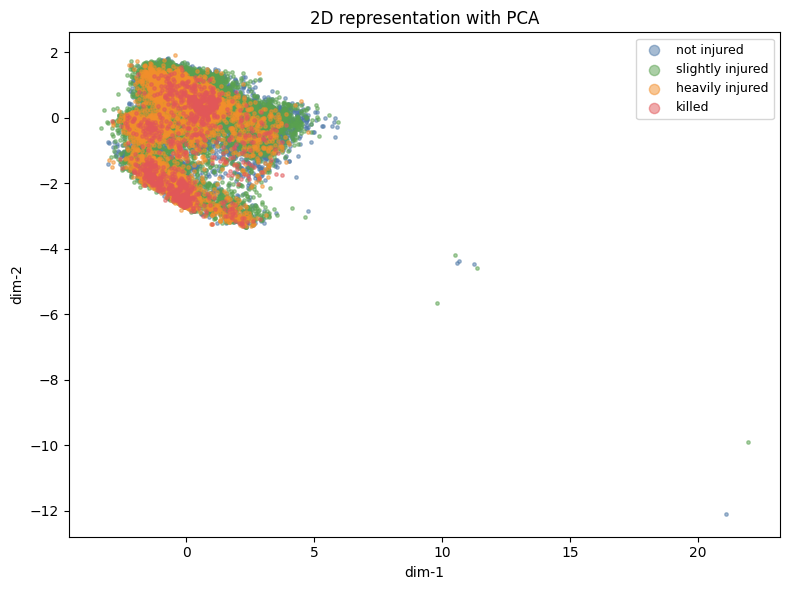

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Optional UMAP (if installed)
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

# Build preprocessing to numeric space
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), [c for c in X_train.columns if c not in num_cols]),
    ('num', StandardScaler(), num_cols),
], remainder='drop')

# Fit on train+test for a shared embedding space
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y_all = pd.concat([y_train, y_test], axis=0, ignore_index=True)

X_all_num = pre.fit_transform(X_all)

# Choose method: 'pca', 'tsne', or 'umap' (if available)
method = 'pca'  # change to 'tsne' or 'umap' as needed
rs = 42

if method == 'pca':
    reducer = PCA(n_components=2, random_state=rs)
    Z = reducer.fit_transform(X_all_num)
elif method == 'tsne':
    # t-SNE can be slow; consider subsampling for very large datasets
    reducer = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=rs, verbose=0, n_jobs=-1)
    Z = reducer.fit_transform(X_all_num)
elif method == 'umap' and HAS_UMAP:
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=rs)
    Z = reducer.fit_transform(X_all_num)
else:
    raise ValueError("Set method to 'pca', 'tsne', or 'umap' (install umap-learn).")

# Optional: subsample for plotting speed
max_points = 40000
if Z.shape[0] > max_points:
    rng = np.random.RandomState(rs)
    idx = rng.choice(Z.shape[0], size=max_points, replace=False)
    Zp = Z[idx]
    yp = y_all.iloc[idx].to_numpy()
else:
    Zp = Z
    yp = y_all.to_numpy()

# Prepare a small helper for labels/colors
label_names = {1:'not injured', 2:'slightly injured', 3:'heavily injured', 4:'killed'}
colors = {1:'#4e79a7', 2:'#59a14f', 3:'#f28e2b', 4:'#e15759'}

plt.figure(figsize=(8, 6))
for k in sorted(np.unique(yp)):
    m = (yp == k)
    plt.scatter(Zp[m, 0], Zp[m, 1], s=6, alpha=0.5, c=colors.get(k, '#888888'), label=label_names.get(k, str(k)))
plt.title(f'2D representation with {method.upper()}')
plt.xlabel('dim-1')
plt.ylabel('dim-2')
plt.legend(markerscale=3, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# Keep for later use if needed
embed_2d = pd.DataFrame({'x': Z[:, 0], 'y': Z[:, 1], 'label': y_all.to_numpy()})

TF: 2.20.0 Built with CUDA: False
GPUs: []
Epoch 1/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.0403 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 2/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0325 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 3/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0310 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 4/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0302 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 5/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0297 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 6/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0293 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 7/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0290 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 8/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0286 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 9/200
249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - los

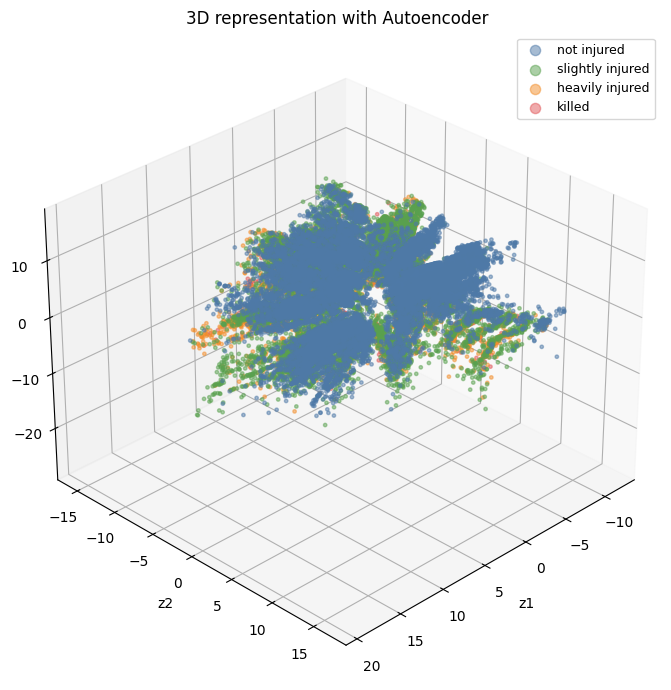

In [17]:
# Autoencoder -> 3D latent embedding

import numpy as np
import pandas as pd

# Ensure we have numeric matrix and labels (re-use your preprocessing)
# X_all_num: numeric array from ColumnTransformer
# y_all: labels concatenated from train/test
assert 'X_all_num' in globals() and 'y_all' in globals(), "Run the preprocessing cell that builds X_all_num and y_all first."

# Install/import TF before this cell; restart kernel after installing GPU support.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras import mixed_precision

print('TF:', tf.__version__, 'Built with CUDA:', tf.test.is_built_with_cuda())
gpus = tf.config.list_physical_devices('GPU')
print('GPUs:', gpus)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print('Memory growth not set:', e)

# Mixed precision (speeds up on modern GPUs)
mixed_precision.set_global_policy('mixed_float16')

tf.random.set_seed(42)
np.random.seed(42)

Xn = X_all_num.astype('float32')
input_dim = Xn.shape[1]

# Encoder
inp = keras.Input(shape=(input_dim,), name='inp')
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(inp)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
latent = layers.Dense(3, name='latent')(x)  # stays float16 under policy

# Decoder
x = layers.Dense(32, activation='relu')(latent)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
# IMPORTANT: final layer to float32 for stable MSE when using mixed precision
out = layers.Dense(input_dim, activation='linear', dtype='float32', name='recon')(x)

encoder = keras.Model(inp, latent, name='encoder')
autoenc = keras.Model(inp, out, name='autoencoder')

# Use CUDA + XLA JIT
autoenc.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', jit_compile=True)

es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

with tf.device('/GPU:0'):
    hist = autoenc.fit(
        Xn, Xn,
        epochs=100,
        batch_size=2048,   # raise if VRAM allows, lower if OOM
        shuffle=True,
        validation_split=0.1,
        callbacks=[es, rlrop],
        verbose=1
    )

with tf.device('/GPU:0'):
    Z = encoder.predict(Xn, batch_size=4096)
Z = Z.astype('float32')

# Optional: subsample for plotting speed
rs = 42
max_points = 40000
if Z.shape[0] > max_points:
    rng = np.random.RandomState(rs)
    idx = rng.choice(Z.shape[0], size=max_points, replace=False)
    Zp = Z[idx]
    yp = y_all.iloc[idx].to_numpy()
else:
    Zp = Z
    yp = y_all.to_numpy()

# Matplotlib 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

label_names = {1:'not injured', 2:'slightly injured', 3:'heavily injured', 4:'killed'}
colors = {1:'#4e79a7', 2:'#59a14f', 3:'#f28e2b', 4:'#e15759'}

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
for k in sorted(np.unique(yp)):
    m = (yp == k)
    ax.scatter(Zp[m, 0], Zp[m, 1], Zp[m, 2], s=6, alpha=0.5,
               c=colors.get(k, '#888888'), label=label_names.get(k, str(k)))

ax.set_title('3D representation with Autoencoder')
ax.set_xlabel('z1'); ax.set_ylabel('z2'); ax.set_zlabel('z3')
ax.view_init(elev=30, azim=45)
ax.legend(markerscale=3, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# Optional Plotly (interactive rotate)
import plotly.express as px
df_plot = pd.DataFrame({'x': Zp[:,0], 'y': Zp[:,1], 'z': Zp[:,2], 'label': yp})
df_plot['label_name'] = df_plot['label'].map(label_names)
fig = px.scatter_3d(df_plot, x='x', y='y', z='z', color='label_name',
                    color_discrete_map={'not injured': colors[1], 'slightly injured': colors[2],
                                       'heavily injured': colors[3], 'killed': colors[4]},
                    opacity=0.6)
fig.update_traces(marker=dict(size=2))
fig.update_layout(title='3D representation with Autoencoder')
fig.show()

# Save embedding for later use
embed_3d_ae = pd.DataFrame({'x': Z[:,0], 'y': Z[:,1], 'z': Z[:,2], 'label': y_all.to_numpy()})

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

X = embed_3d_ae.drop(columns='label')
y = embed_3d_ae['label']

X_train, X_test, y_train, y_test = train_test_split(X, y)

classifier = SVC(kernel='rbf')

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['uninjured', 'slightly injured', 'heavily injured', 'killed']
).show()